In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing.preprocessing import *

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils.plotting import *
from model.cnn import *
from model.gru import *
from model.lstm import *
from model.metrics import *
from model.unet import *

In [2]:
#import data
bnp_data = pd.read_csv("../cleaned_data.csv")
bnp_data = add_features(bnp_data, window_sizes=[5, 10])
bnp_data.describe()

,Adj Close,Close,High,Low,Open,Volume,Log Return,ma_close_5,ma_volume_5,ma_close_10,ma_volume_10
count,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3.043000e+03,3043.000000,3043.000000,3.043000e+03,3043.000000,3.043000e+03
mean,36.470400,52.141603,52.753374,51.537340,52.160959,3.989900e+06,0.000324,36.444758,3.989962e+06,36.411311,3.991269e+06
std,11.221611,8.747804,8.709128,8.762270,8.731383,1.962344e+06,0.019515,11.190984,1.526323e+06,11.150848,1.384754e+06
min,17.095335,24.670000,25.340000,24.504999,24.900000,0.000000e+00,-0.191166,17.500025,9.809828e+05,18.094585,1.360922e+06
25%,28.002009,45.722500,46.414999,45.154999,45.802500,2.753874e+06,-0.009222,28.018136,3.009407e+06,28.023578,3.119302e+06
50%,33.479767,52.700001,53.209999,52.099998,52.720001,3.559610e+06,0.000588,33.477187,3.769687e+06,33.399057,3.781072e+06
75%,41.960367,58.599998,59.250000,58.029999,58.689999,4.682802e+06,0.010263,41.962991,4.612006e+06,42.054534,4.559531e+06
max,68.339996,72.900002,73.080002,72.290001,72.349998,2.133924e+07,0.165351,67.799724,1.422400e+07,67.577721,1.246760e+07


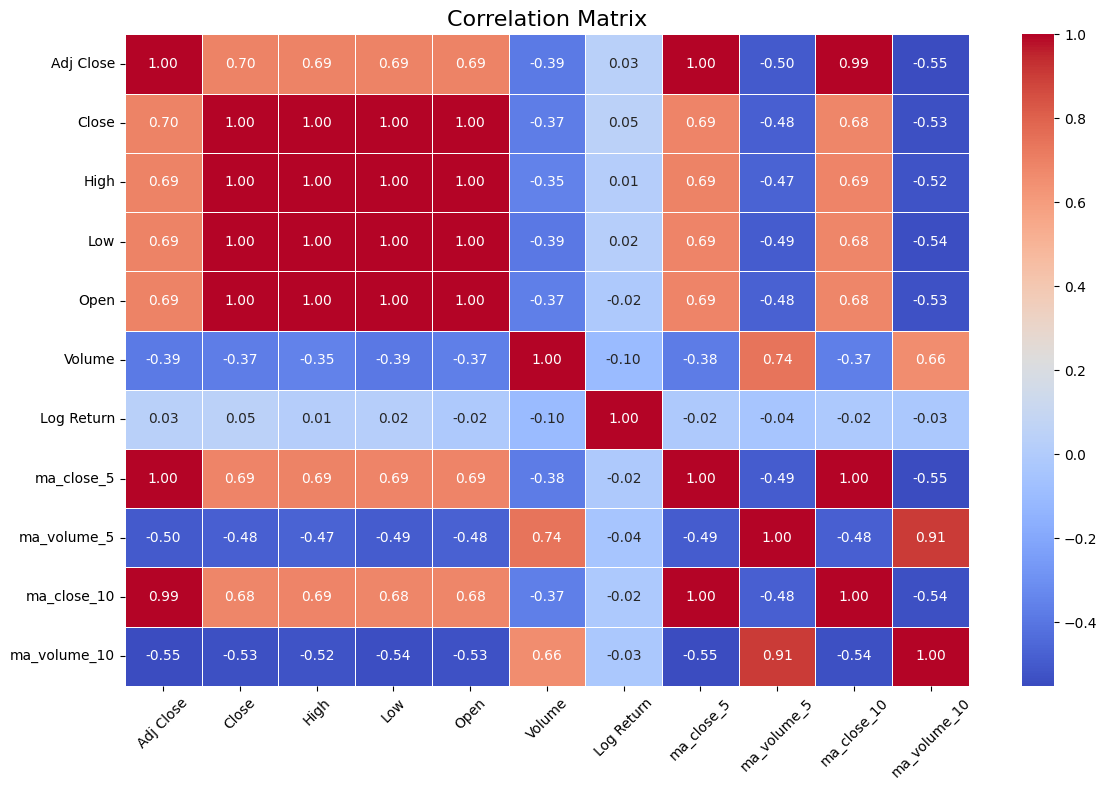

In [3]:
plot_correlation_matrix(bnp_data[bnp_data.columns[1:]])

In [4]:
features=['Adj Close', 'Close', 'Volume','Log Return','ma_close_10','ma_volume_5']

In [5]:
gap = 100  # Gap between each subset

total_samples = len(bnp_data)
train_size = int(0.58 * total_samples)
test_size = int(0.17 * total_samples)
validation_size = int(0.17 * total_samples)

train,test,validation=data_splitting(bnp_data,train_size,test_size,validation_size,gap)

In [6]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scaler for the target to inverse transform y_pred 
target = train[['Adj Close']]
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Scaler for the training dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[features])
scaled_train = pd.DataFrame(scaled_train, columns=features)

# Applying the scaler of the training set onto test and validation set
scaled_test = scaler.transform(test[features])
scaled_test = pd.DataFrame(scaled_test, columns=features)

scaled_validation = scaler.transform(validation[features])
scaled_validation = pd.DataFrame(scaled_validation, columns=features)

<h2>LSTM Model</h2>

In [7]:
timesteps = 10
X_train, y_train = create_sequences(scaled_train, target_column='Adj Close', timesteps=timesteps)
X_test, y_test = create_sequences(scaled_test, target_column='Adj Close', timesteps=timesteps)
X_validation, y_validation = create_sequences(scaled_validation, target_column='Adj Close', timesteps=timesteps)

In [8]:
# Build and train the LSTM model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))  # Input shape (timesteps, features)
model.summary()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    min_delta=0.001,        # Minimum improvement in loss to qualify as progress
    restore_best_weights=True  # Restores weights from the best epoch
)

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,   # Reduce learning rate by half
    patience=5,   # Wait 5 epochs with no improvement
    min_lr=1e-6   # Minimum learning rate
)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),callbacks=[early_stopping])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 16)         │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,601 (14.07 KB)

 Trainable params: 3,601 (14.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4067 - val_loss: 0.2060
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1466 - val_loss: 0.1041
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0724 - val_loss: 0.0518
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0426 - val_loss: 0.0399
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0305 - val_loss: 0.0404
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 - val_loss: 0.0377
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0239
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157 - val_loss: 0.0215
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146 - val_loss: 0.0380
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0211
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 - val_loss: 0.0206
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [9]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 2.2900
NSE: 0.9337


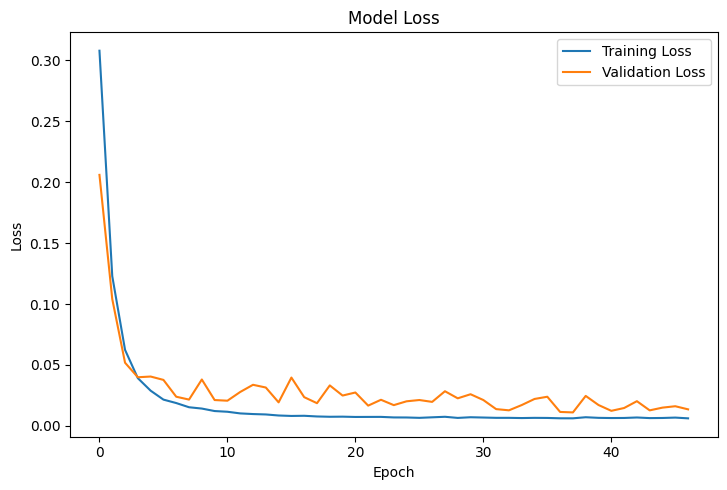

In [10]:
plot_learning_curves(history)

The gap between training and validation loss shows the model fits the training data too well but struggles to generalize.

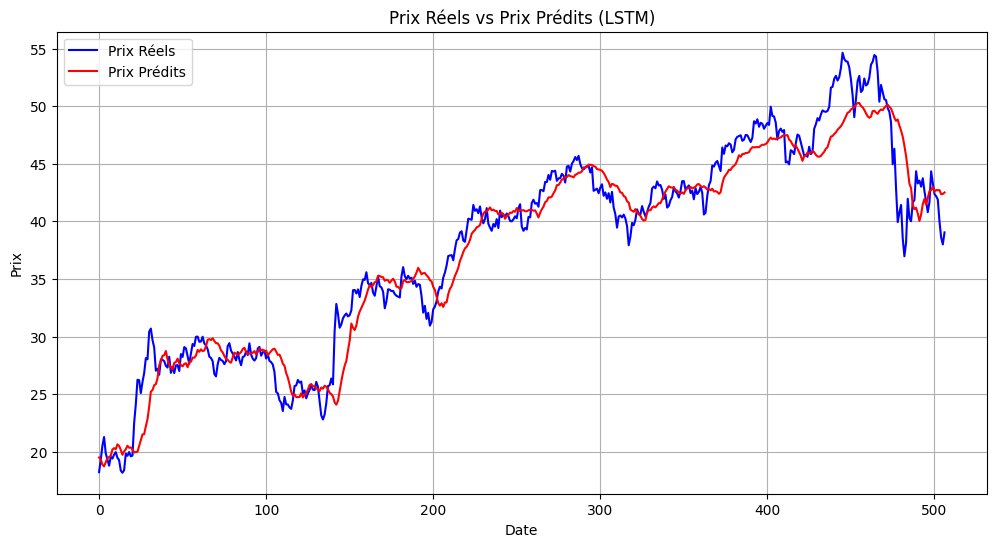

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2> GRU Model</h2>

In [12]:
gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.summary()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    min_delta=0.001,        # Minimum improvement in loss to qualify as progress
    restore_best_weights=True  # Restores weights from the best epoch
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0919 - val_loss: 0.0665
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0338 - val_loss: 0.0459
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0235 - val_loss: 0.0269
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0192 - val_loss: 0.0236
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0156 - val_loss: 0.0176
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0130 - val_loss: 0.0158
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0132
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0113 - val_loss: 0.0129
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0104 - val_loss: 0.0109
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [14]:
# Predict and evaluate
y_pred = gru_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 1.2810
NSE: 0.9792


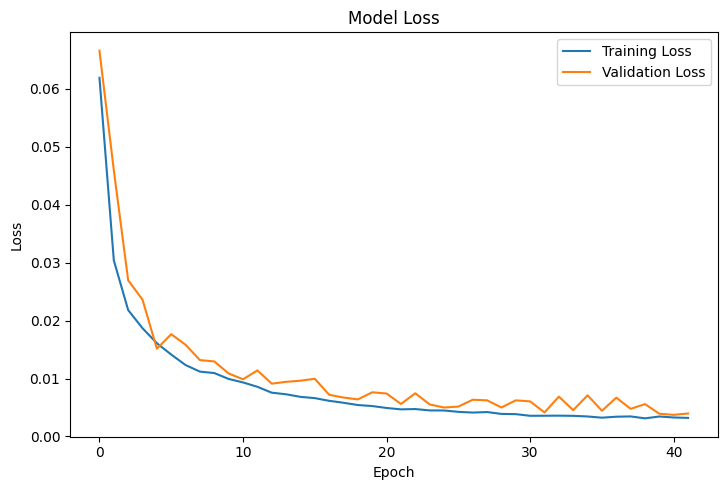

In [15]:
plot_learning_curves(gru_history)

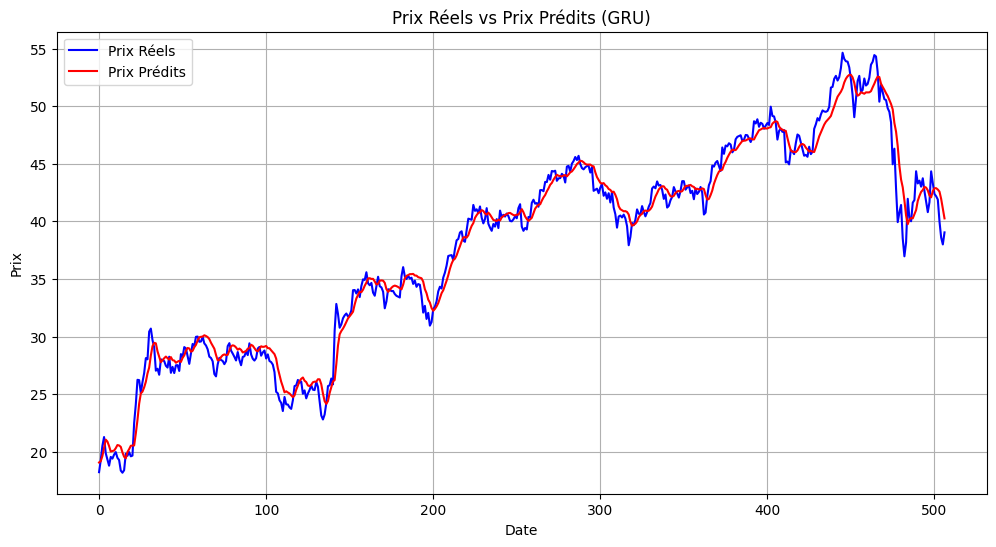

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (GRU)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>CNN Model</h2>

In [17]:
cnn1d_model = build_cnn1d_model((X_train.shape[1], X_train.shape[2]))  
cnn1d_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,869 (65.89 KB)

 Trainable params: 16,869 (65.89 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    min_delta=0.001,        # Minimum improvement in loss to qualify as progress
    restore_best_weights=True  # Restores weights from the best epoch
)

cnn1d_history = cnn1d_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0702 - val_loss: 0.0677
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_loss: 0.0720
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0625
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0357
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0514
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0367
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0474
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0572
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0378
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0230
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0345
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

In [19]:
# Predict and evaluate
y_pred = cnn1d_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 1.9930
NSE: 0.9498


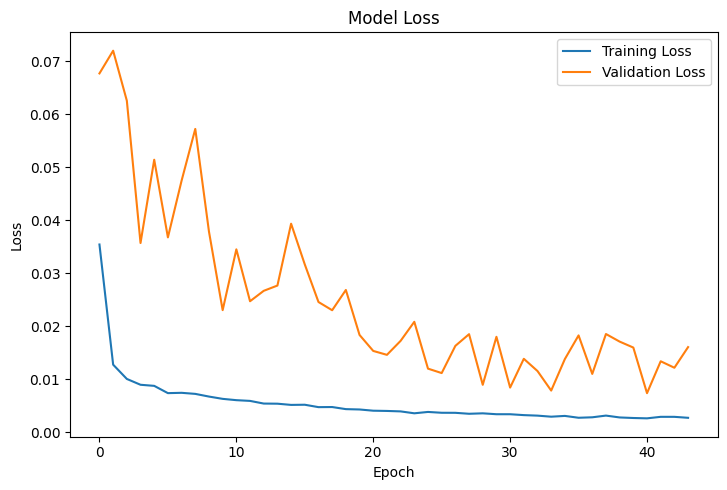

In [20]:
plot_learning_curves(cnn1d_history)

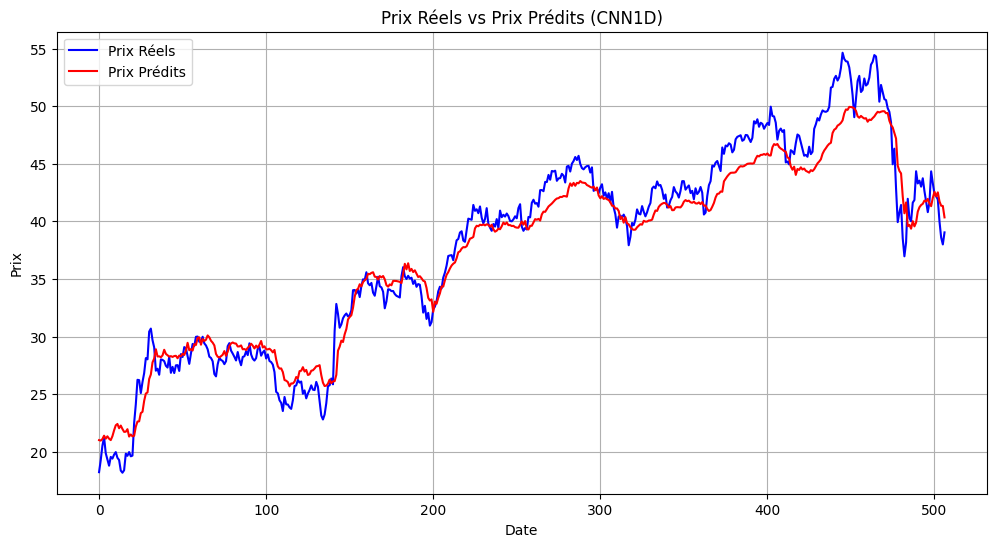

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (CNN1D)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>Deeper CNN</h2>

In [22]:
cnndeep_model = build_cnn1d_deep_model((X_train.shape[1], X_train.shape[2]))  
cnndeep_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,169 (360.04 KB)

 Trainable params: 91,529 (357.54 KB)

 Non-trainable params: 640 (2.50 KB)

In [23]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores weights from the best epoch
)

cnndepp_history = cnndeep_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3717 - val_loss: 0.4892
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0564 - val_loss: 0.3762
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0338 - val_loss: 0.3044
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.2386
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.1419
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191 - val_loss: 0.0818
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - val_loss: 0.0434
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - val_loss: 0.0837
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0599
Epoch 10/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0116
Epoch 11/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.0534
Epoch 12/100
110/110 ━━━━━━━━━━━━━━━━━━━━

In [24]:
# Predict and evaluate
y_pred = cnndeep_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 2.4259
NSE: 0.9256


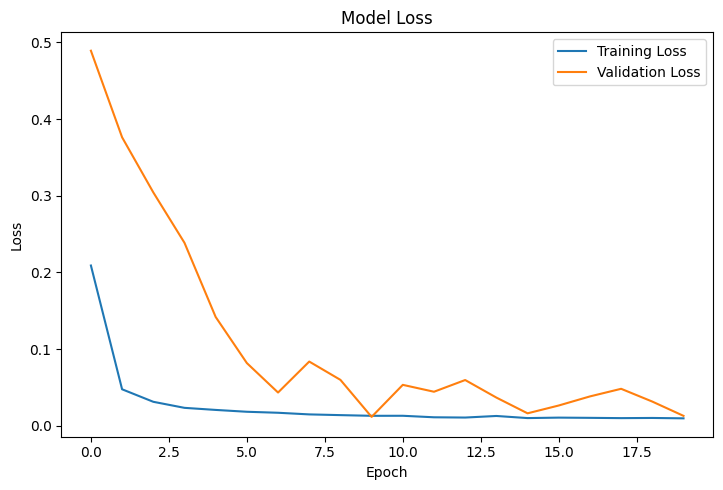

In [25]:
plot_learning_curves(cnndepp_history)

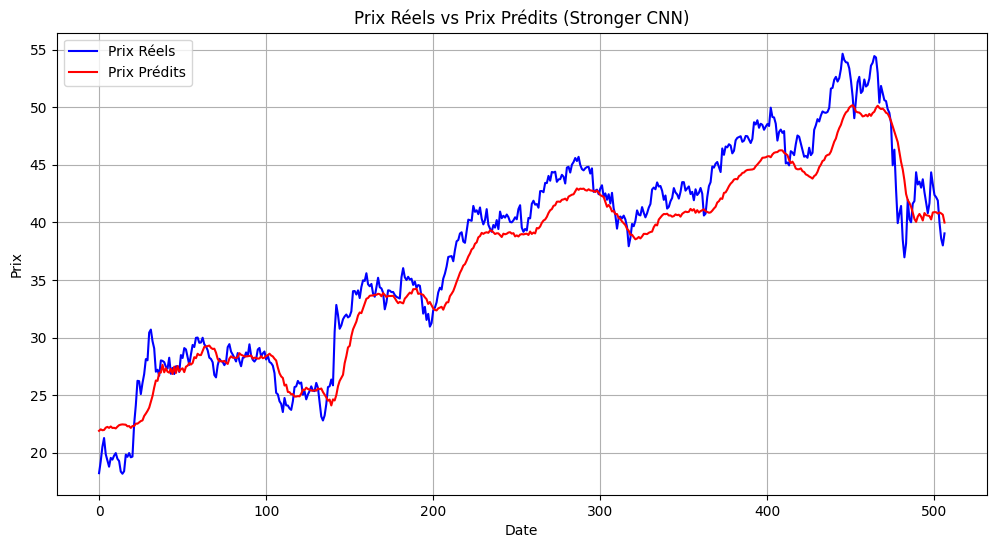

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (Stronger CNN)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>Stronger CNN</h2>

In [27]:
lstmcnn_model = build_lstm_cnn((X_train.shape[1], X_train.shape[2]))  
lstmcnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 8, 128)         │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,569 (428.00 KB)

 Trainable params: 109,569 (428.00 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores weights from the best epoch
)

lstmcnn_history = lstmcnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0759 - val_loss: 0.0439
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0252
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0324
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0357
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0172
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0249
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0451
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0334
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0310
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0328
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0277
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

In [29]:
# Predict and evaluate
y_pred = lstmcnn_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RMSE: 2.9546
NSE: 0.8896


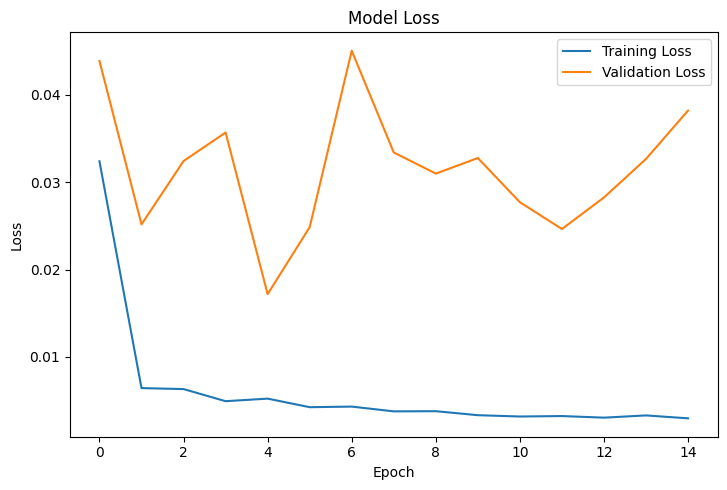

In [30]:
plot_learning_curves(lstmcnn_history)

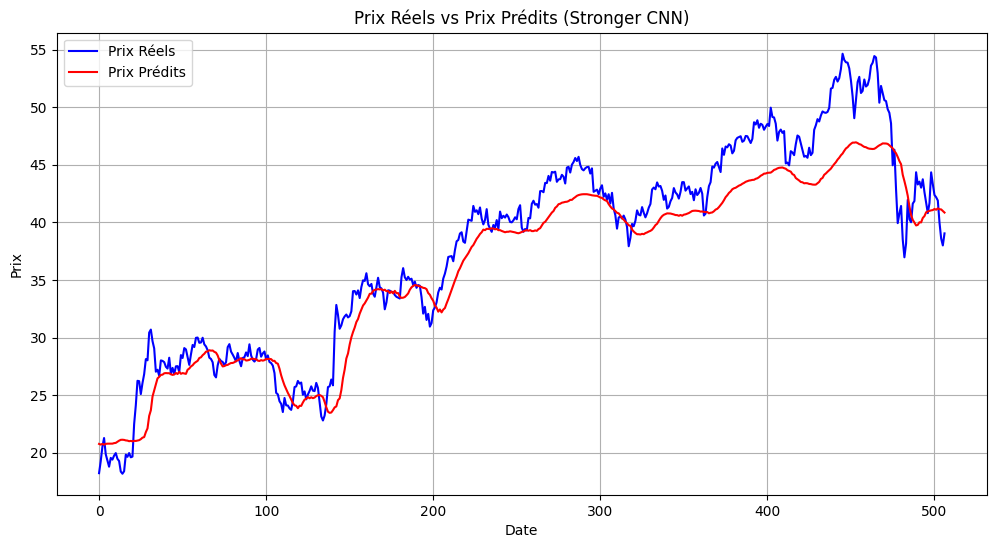

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (Stronger CNN)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>Performance comparison with a y[t]=y[t-1] model</h2>

In [32]:
import numpy as np
import pandas as pd

def create_shifted_timeseries(x):
    """
    Create a time series y from x such that:
        y[t] = x[t-1] for t > 0
        y[0] = x[0]
        
    Parameters:
        x (array-like): The input time series.
        
    Returns:
        y (np.ndarray): The shifted time series.
    """
    y = np.zeros_like(x)  # Initialize y with the same shape as x
    y[0] = x[0]           # Set the first value of y to the first value of x
    y[1:] = x[:-1]        # Set y[t] = x[t-1] for t > 0
    return y

y_pred=create_shifted_timeseries(y_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

RMSE: 0.8728
NSE: 0.9904


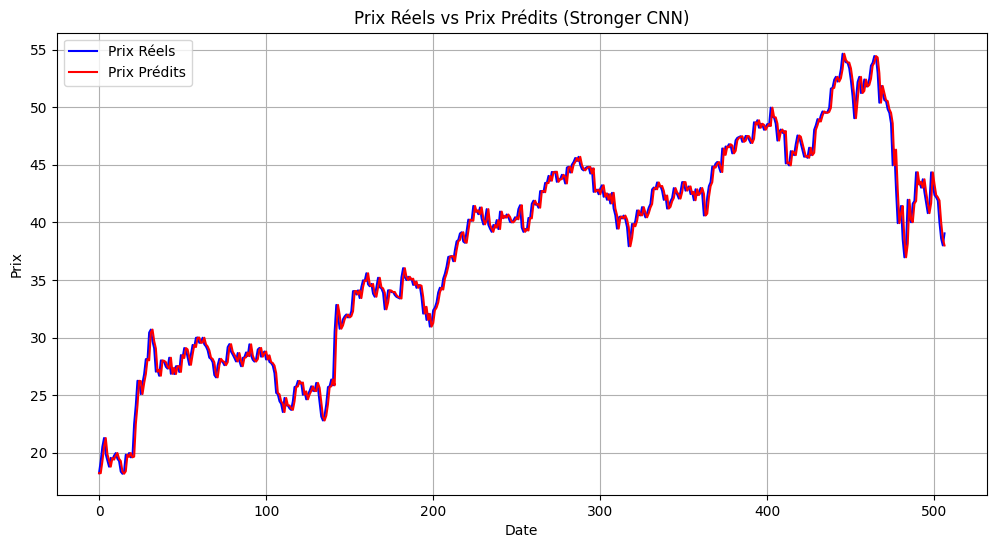

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (Stronger CNN)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()